# Single Pixel Study

- [MNIST](#MNIST)
- [CIFAR-10](#CIFAR-10)
- [OTHER](#OTHER)

In [1]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per

import pickle, gzip
import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [52]:
import imp
imp.reload(per);
imp.reload(ml);

## MNIST

In [2]:
# !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-21 18:52:42--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.2’

mnist.pkl.gz.2      100%[===================>]  15.42M  7.94MB/s    in 1.9s    

2019-11-21 18:52:45 (7.94 MB/s) - ‘mnist.pkl.gz.2’ saved [16168813/16168813]



In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [10]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       max_pooling_kernels_and_stride=[(2, 2)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=True, random_seed=12)

nnet.train(Xtrain, Ttrain, n_epochs=50, batch_size=1500,
           optim='Adam', learning_rate=0.05, verbose=True)

Epoch 5 error 0.20818
Epoch 10 error 0.18575
Epoch 15 error 0.16206
Epoch 20 error 0.16475
Epoch 25 error 0.15623
Epoch 30 error 0.16229
Epoch 35 error 0.16481
Epoch 40 error 0.17837
Epoch 45 error 0.16788
Epoch 50 error 0.17044


In [11]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            max_pooling_kernels_and_stride=[(2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (norm_0): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop_0): Dropout(p=0.2, inplace=False)
  (flatten): Flatten()
  (output_1): Linear(in_features=160, out_features=10, bias=True)
)
   Network was trained for 50 epochs with a batch size of 1500 and took 6.1173 seconds.
   Final objective value is 0.170

In [14]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])
test_percent  = ml.percent_correct(Ttest, nnet.use(Xtest)[0])

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 97.516%, Test Percentage: 97.420%


In [15]:
_ = ml.confusion_matrix(Ttest, nnet.use(Xtest)[0], np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 99.1  0    0    0.1  0    0    0.4  0.1  0.3  0  
 1 |  0   98.8  0.4  0.1  0    0    0.4  0.1  0.3  0  
 2 |  0.5  0.2 96.7  0.6  0    0    0.2  0.7  1.2  0  
 3 |  0    0    0.4 98.1  0.1  0.4  0    0.3  0.4  0.3
 4 |  0    0.2  0.3  0.1 97.6  0    0.3  0.3  0    1.2
 5 |  0.3  0    0.1  1.2  0   97.3  0.3  0.2  0.2  0.2
 6 |  1.0  0.4  0.1  0    0.3  0.3 97.6  0    0.2  0  
 7 |  0.2  0.2  1.1  0.2  0    0    0   97.7  0    0.7
 8 |  0.6  0    0.4  0.2  0.2  0.3  0.3  0.6 96.7  0.6
 9 |  0.7  0.5  0.4  0.5  0.8  0.5  0    1.5  0.6 94.5


### Pixels

Total of 694 misclassified samples,
      with a 7.360% difference from test by changing 1 pixel(s)
(10000, 1, 28, 28) (10000, 1, 28, 28)


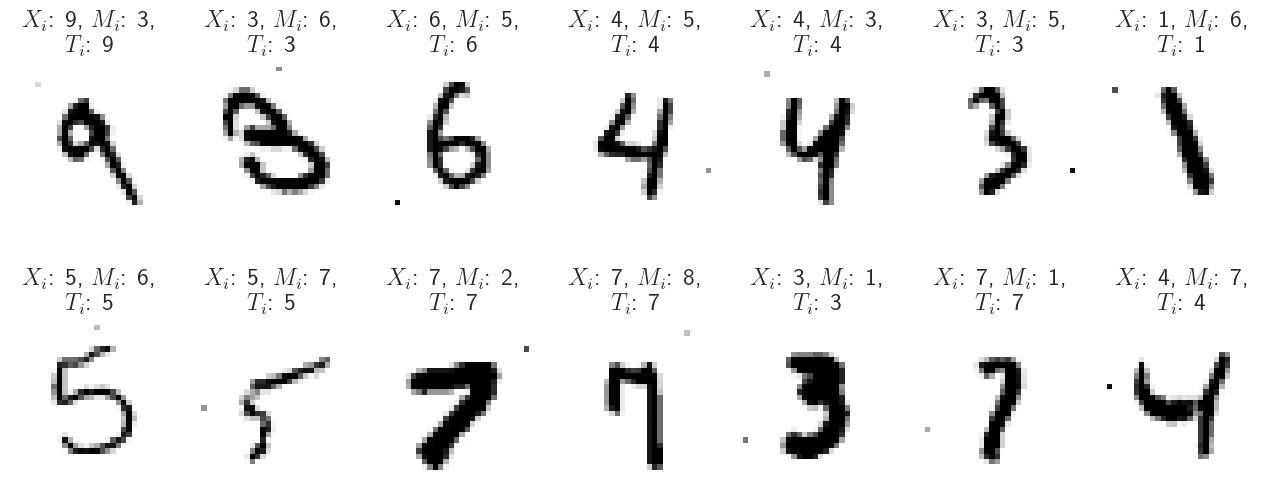

(10000, 1, 28, 28) (10000, 1, 28, 28)


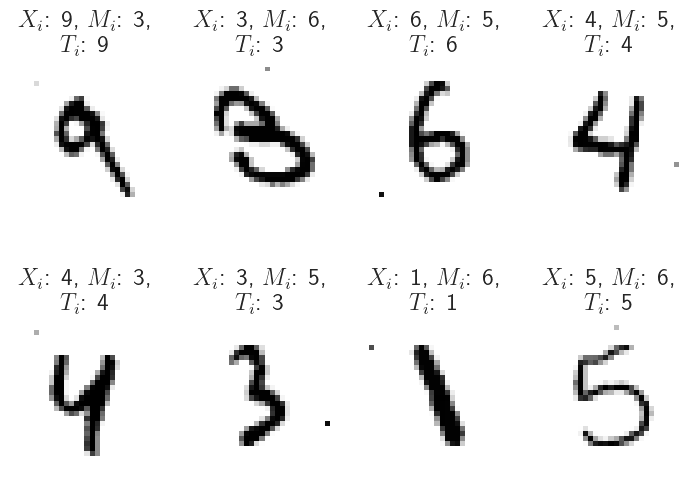

In [16]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change, pertrub='stuck')

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           name='media/mnist_example_single_1px.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           display='grid', name='media/mnist_example_grid_1px.pdf')

FloatProgress(value=0.0, max=375.0)

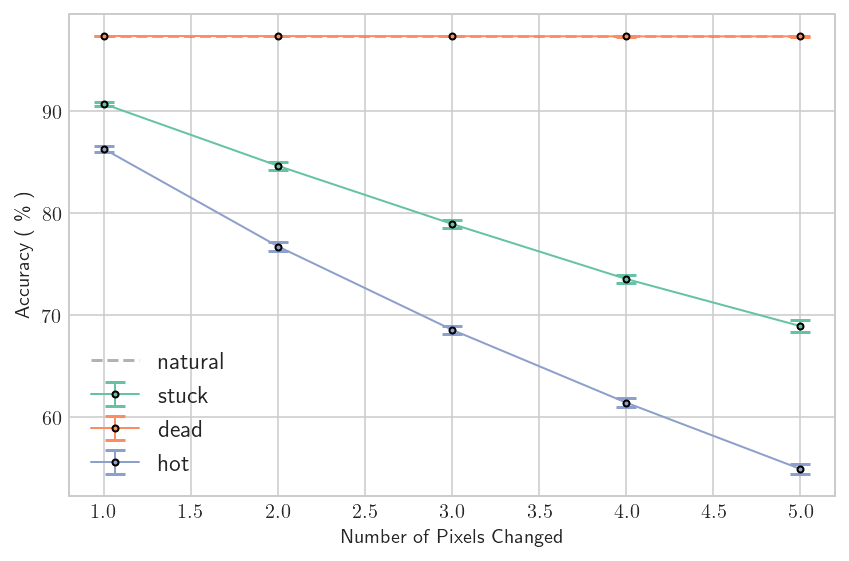

In [17]:
per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/mnist_change_5px.pdf')

### Noise

Total of 7954 misclassified samples,
      with a 81.730% difference from test by adding noise with 0.05
(10000, 1, 28, 28) (10000, 1, 28, 28)


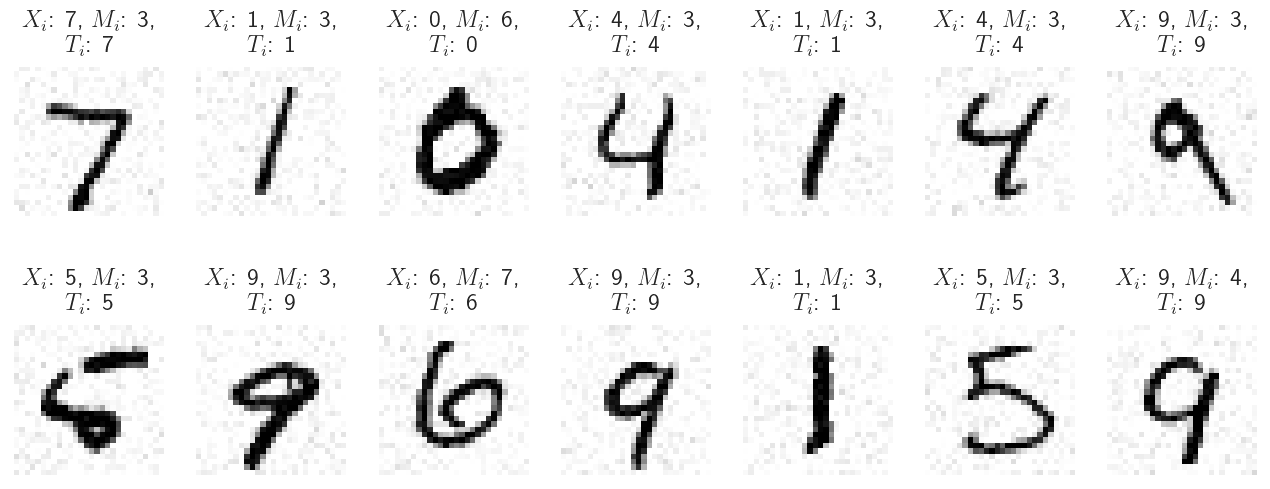

(10000, 1, 28, 28) (10000, 1, 28, 28)


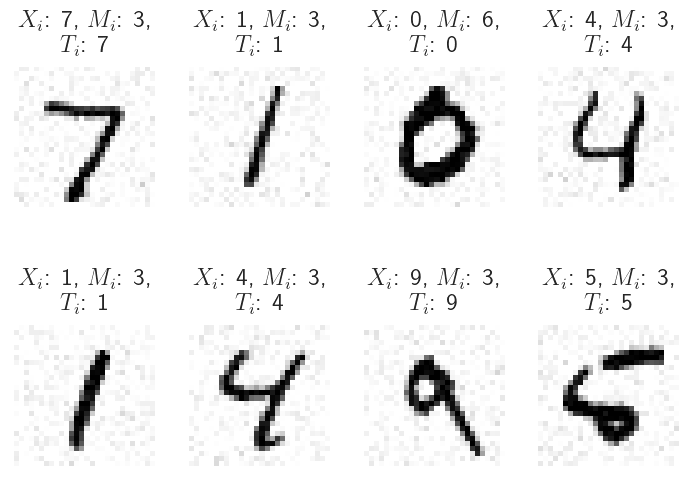

In [31]:
noise_variance = 0.05
Xcopy = per.add_image_noise(Xtest, noise_variance)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by adding noise with {noise_variance}''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           name='media/mnist_example_single_1var_noise.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           display='grid', name='media/mnist_example_grid_1var_noise.pdf')

FloatProgress(value=0.0, max=125.0)

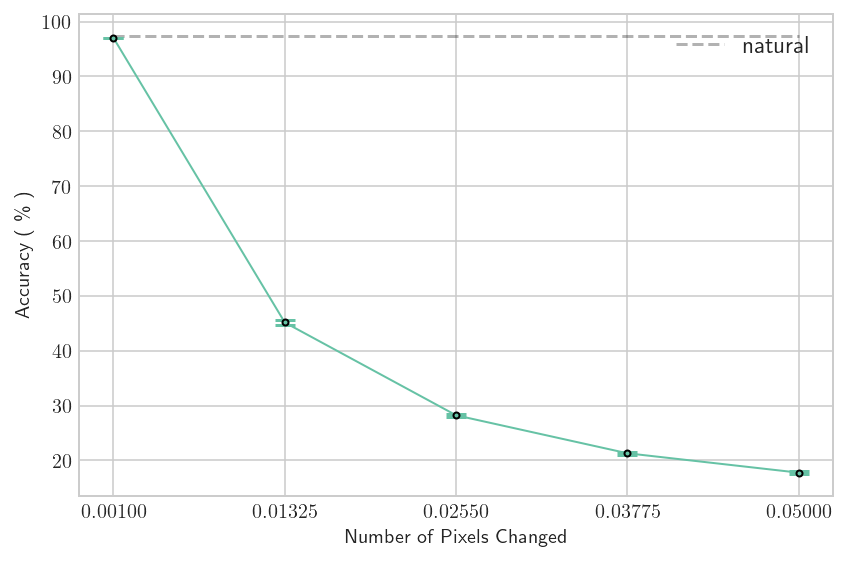

In [30]:
per.test_increasing_noise(nnet, Xtest, Ttest, (0.001, 0.05), 5, 25, 
                          name='media/mnist_change_var_noise.pdf')

## CIFAR-10

In [10]:
!curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  46.4M      0  0:00:03  0:00:03 --:--:-- 46.4M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
def load(file_name):
    data = []
    
    for file in glob.glob('cifar-10-batches-py/' + file_name):
        with open(file, 'rb') as fo:
            data.append(pickle.load(fo, encoding='bytes'))
            
    images = np.array(data[0][b'data'])
    labels = np.array(data[0][b'labels'])

    if len(data) > 1:
        for i in range(1, len(data)):
            images = np.concatenate((images, data[i][b'data']), axis=0)
            labels = np.concatenate((labels, data[i][b'labels']), axis=0)
    
    return (images.reshape(-1, 3, 32, 32)/255.0).astype(np.float32), labels.reshape((-1, 1))

Xtrain, Ttrain = load('data_batch_*')
Xtest, Ttest, = load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']

(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


In [3]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                                   kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                                   max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                                   n_units_in_fc_hidden_layers=[], 
                                   classes=np.unique(Ttrain), use_gpu=True, random_seed=12)

nnet.train(Xtrain, Ttrain, n_epochs=20, batch_size=100,
           optim='Adam', learning_rate=0.0005, verbose=True)

Epoch 2 error 0.59585
Epoch 4 error 0.51125
Epoch 6 error 0.33025
Epoch 8 error 0.29507
Epoch 10 error 0.18536
Epoch 12 error 0.17198
Epoch 14 error 0.16905
Epoch 16 error 0.11789
Epoch 18 error 0.09894
Epoch 20 error 0.06104


In [4]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=3,
                            image_size=32,
                            n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                            kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                            max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [5]:
train_percent = ml.percent_correct(ml.batched_use(nnet, Xtrain), Ttrain)
test_percent  = ml.percent_correct(ml.batched_use(nnet, Xtest), Ttest)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 99.134%, Test Percentage: 86.460%


In [6]:
_ = ml.confusion_matrix(Ttest, ml.batched_use(nnet, Xtest), np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 88.5  1.0  1.5  0.4  1.2  0.1  0.7  0.4  5.7  0.5
 1 |  0.4 93.9  0.2  0.2  0.1  0.1  0.5  0    1.8  2.8
 2 |  4.8  0   79.2  3.0  4.1  3.9  3.5  0.7  0.7  0.1
 3 |  2.0  0.2  3.9 72.2  4.1  8.3  5.8  0.6  1.8  1.1
 4 |  0.4  0.1  2.7  2.5 88.7  1.9  2.0  1.0  0.6  0.1
 5 |  1.0  0.2  2.5 11.0  3.6 78.7  1.5  0.8  0.5  0.2
 6 |  0.6  0    1.9  1.4  1.5  0.4 93.3  0.3  0.4  0.2
 7 |  0.7  0    1.6  2.6  4.7  3.5  0.5 85.6  0.5  0.3
 8 |  1.8  0.6  0.4  0.2  0.3  0.1  0.3  0   95.8  0.5
 9 |  1.4  5.6  0.3  0.4  0.2  0.1  0.5  0.1  2.7 88.7


### Pixels

Total of 129 misclassified samples,
      with a 2.440% difference from test by changing 1 pixel(s)
(10000, 3, 32, 32) (10000, 3, 32, 32)


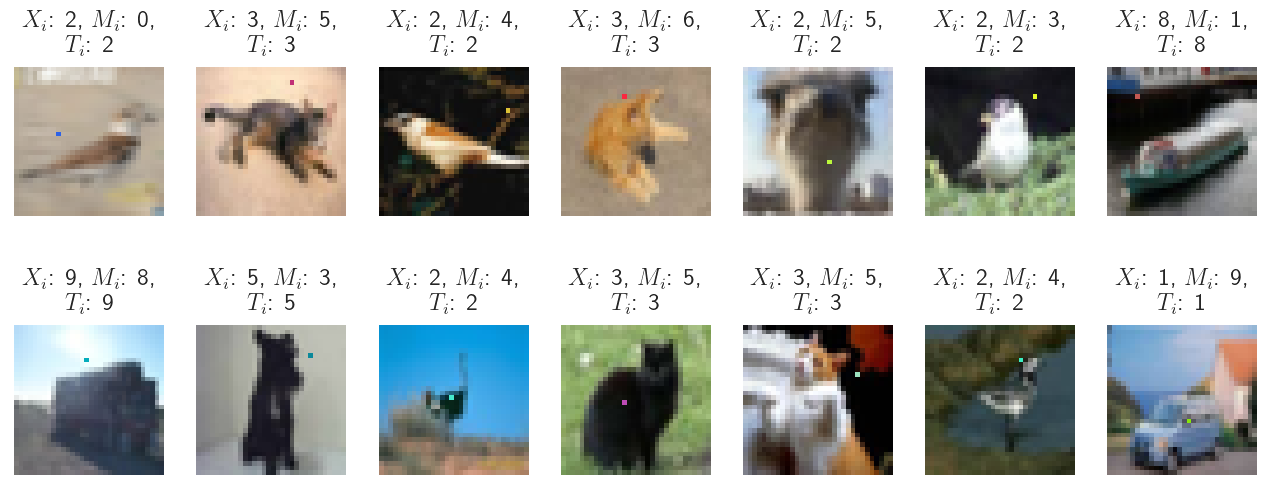

(10000, 3, 32, 32) (10000, 3, 32, 32)


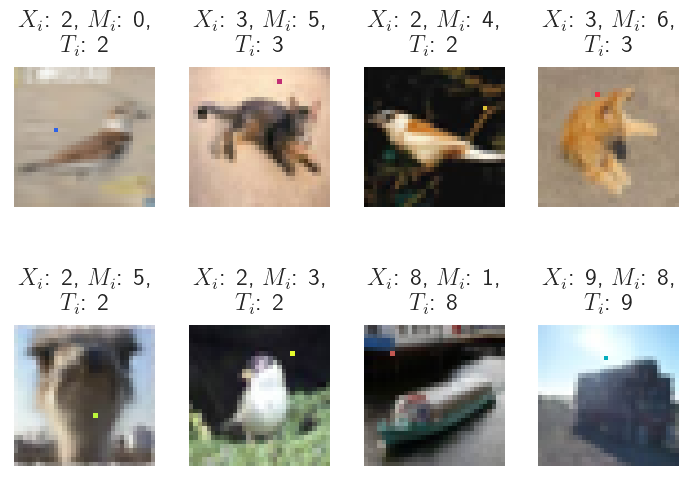

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [7]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change, pertrub='stuck')

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_single_1px_stuck.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           display='grid', name='media/cifar_example_grid_1px_stuck.pdf')

print(class_names)

FloatProgress(value=0.0, max=375.0)

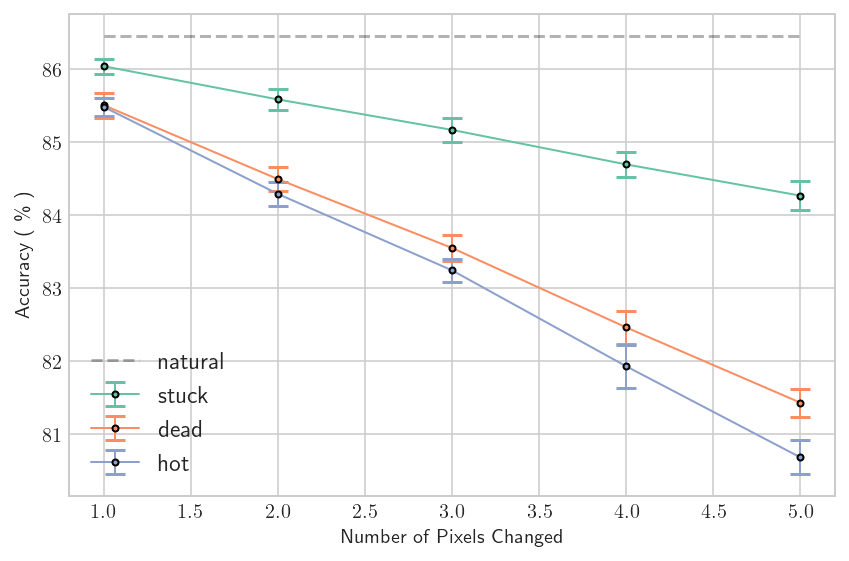

In [8]:
per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/cifar_change_5px_stuck.pdf')

### Noise

Total of 2525 misclassified samples,
      with a 32.500% difference from test by adding noise with 0.05
(10000, 3, 32, 32) (10000, 3, 32, 32)


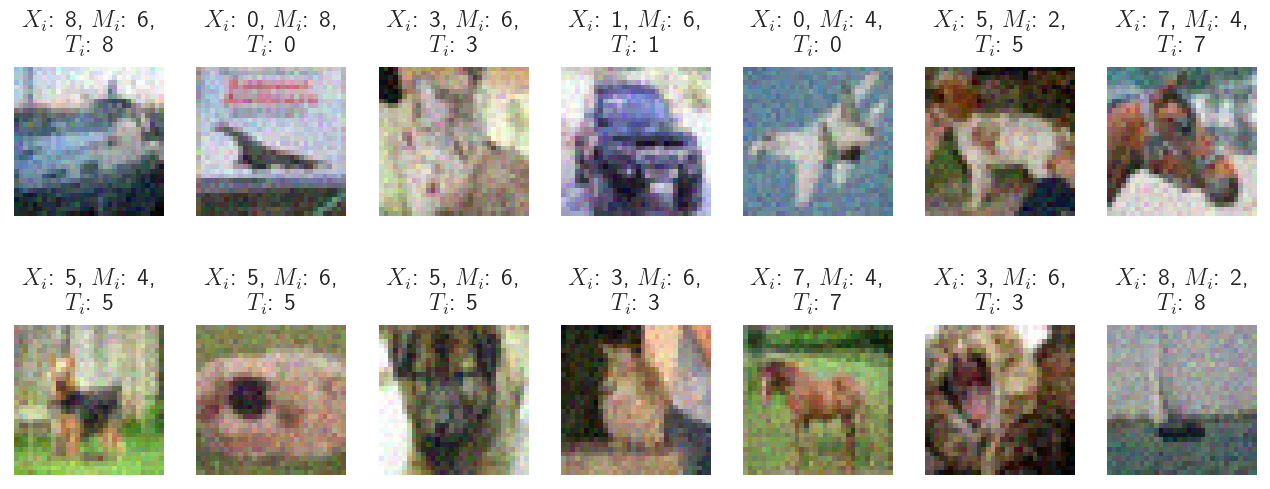

(10000, 3, 32, 32) (10000, 3, 32, 32)


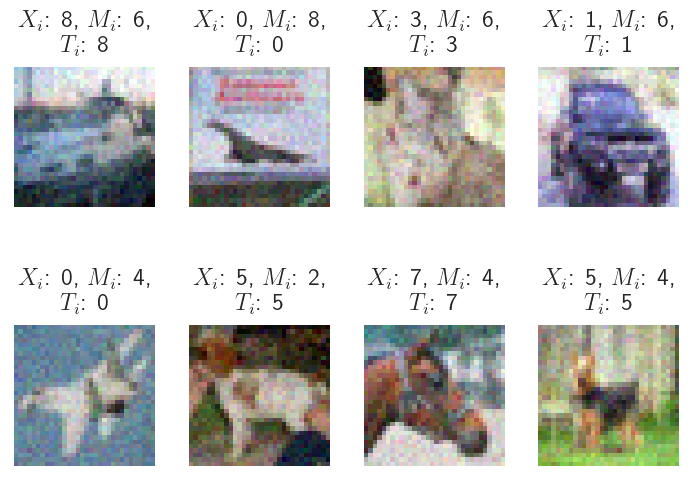

In [10]:
noise_variance = 0.05
Xcopy = per.add_image_noise(Xtest, noise_variance)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by adding noise with {noise_variance}''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR', 
           name='media/cifar_example_single_1var_noise.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR', 
           display='grid', name='media/cifar_example_grid_1var_noise.pdf')

FloatProgress(value=0.0, max=125.0)

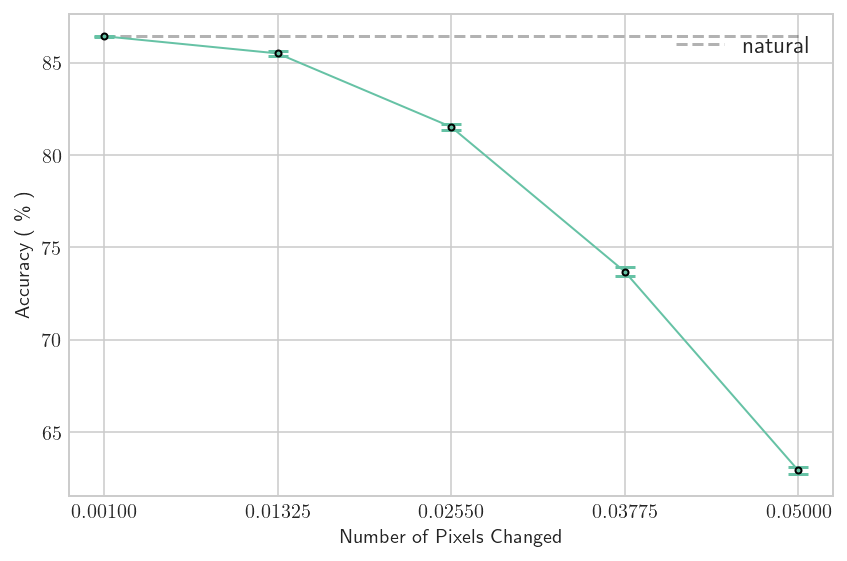

In [11]:
per.test_increasing_noise(nnet, Xtest, Ttest, (0.001, 0.05), 5, 25, 
                          name='media/cifar_change_var_noise.pdf')

## OTHER